# Table of Contents
```
1. Business Understanding
   1.1. Problem Description
2. Data Understanding
   2.1. Import Libraries, Modules, Functions, Objects, etc.
   2.2. User Defined Functions (UDFs)
   2.3. Data Loading
   2.4. Exploratory Data Analysis (EDA)
        2.4.1. Text EDA: Understand the raw data with Descriptive Statistics
        2.4.2. Visual EDA: Understand the data with Visualizations
               2.4.2.1. Draw Univariate plots to better understand each attribute
3. Research
   3.1. List of selected algorithms to build models
   3.2. List of model evaluation metrics
4. Data Preprocessing
   4.1. Data Cleaning
        4.1.1. Basic data cleaning
        4.1.2. Handling missing Categorical values
   4.2. Feature Selection
   4.3. Feature Engineering
   4.4. Dimensionality Reduction
   4.5. Split datasets for train-test
        4.5.1. Create Independent(X) and Dependent(y) variables
        4.5.2. Split the dataset into train and test
   4.6. Data Transforms
   4.7. Handling Imbalanced classes
5. Model Development
   5.1. Model definitions
6. Model Training
7. Model Refinement
8. Model Evaluation
9. Final Model Selection
10. Model Validation
11. Model Deployment
```

# 1. Business Understanding

## 1.1. Problem Description

**`Problem statement`**:

`In business terms`: 
* Based on the physical characteristics as described in the dataset *`mushrooms.csv`*, determine whether a given mushroom is edible or poisonous.

`In analytical terms`: 
* Build a predictive model to classify whether a given mushroom is edible or poisonous.
* In order to better vizualize the decision boundaries, perform PCA on the data to reduce the dimensionality to 2 dimensions. 
* Build few models to see how they affect the classifier's decision boundary and accuracy.
* Finally, recommend the best model with highest accuracy score.

**`Type of the problem`**: Supervised Learning - Classification - Univariate - Imbalanced

**`Data source(s)`**: [UCI Machine Learning Repository - Mushroom dataset](http://archive.ics.uci.edu/ml/datasets/Mushroom?ref=datanews.io)
    
**`Author(s)`**: Balasubramanian Chandran

# 2. Data Understanding

## 2.1. Import Libraries, Modules, Functions, Objects, etc.

In [1]:
# Import necessary libraries for this project
import sys         as sys
import numpy       as np
import pandas      as pd
import sklearn     as sk
import seaborn     as sns
import matplotlib  as mpl
import pickle      as pickle
import warnings

# Import necessary Modules, Functions and Objects from the Libraries
from numpy                         import loadtxt
from pandas                        import read_csv
from sklearn.decomposition         import PCA
from imblearn.over_sampling        import SMOTE
from sklearn.model_selection       import train_test_split
from matplotlib                    import pyplot as plt
from sklearn.linear_model          import LogisticRegression, SGDClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.neural_network        import MLPClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, GradientBoostingClassifier
from xgboost                       import XGBClassifier

# Check the versions of the imported libraries
print("Versions of imported libraries:")
print("Python:     {}".format(sys.version))
print("Numpy:      {}".format(np.__version__))
print("Pandas:     {}".format(pd.__version__))
print("skLearn:    {}".format(sk.__version__))
print("Seaborn:    {}".format(sns.__version__))
print("Matplotlib: {}".format(mpl.__version__))

# Optional settings
mpl.style.use('ggplot')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None, 'precision', 3)
warnings.filterwarnings('ignore')

print(__doc__)

Versions of imported libraries:
Python:     3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Numpy:      1.19.5
Pandas:     1.3.2
skLearn:    0.24.2
Seaborn:    0.11.2
Matplotlib: 3.4.2
Automatically created module for IPython interactive environment


## 2.2. User Defined Functions (UDFs)

In [2]:
def plot_histograms(df, features, rows, cols):
    fig = plt.figure(figsize=(14, 16))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        df[feature].hist(bins=20, ax=ax, facecolor='darkgreen')
        ax.set_title(feature, color='brown', size='large')
    #ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
    
def draw_decision_boundary(X, y, model):
    plt.figure(figsize=(8,5), dpi=90)
    for i, ptype in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1, 2, i+1)
        mesh_stepsize = 0.01       # Step size in the mesh
        x_min, x_max  = X[:,0].min() - 0.1, X[:,0].max() + 0.1
        y_min, y_max  = X[:,1].min() - 0.1, X[:,1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_stepsize), np.arange(y_min, y_max, mesh_stepsize))
        if i == 0:
            pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                pred = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                         verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        pred = pred.reshape(xx.shape)
        acc_score = model.score(X, y)
        plt.scatter(X[y.values == 0,0], X[y.values == 0,1], alpha=0.4, label='Edible', s=5)
        plt.scatter(X[y.values == 1,0], X[y.values == 1,1], alpha=0.4, label='Poisonous', s=5)
        plt.imshow(pred, interpolation='nearest', cmap='RdYlBu_r', alpha=0.15, 
                   extent=(x_min, x_max, y_min, y_max), origin='lower')    
        plt.title(ptype + '\n' + str(model).split('(')[0] + ' Test Accuracy: ' + str(np.round(acc_score, 4)),
                  fontsize='medium', alpha=0.7)
        plt.gca().set_aspect('equal')
        for spine in plt.gca().spines:
            plt.gca().spines[spine].set_alpha(0.4)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.2)
    return acc_score

def plot_performance_metrics(scores_list, scores_names, colors, modelnames):
    fig, axes = plt.subplots(1, len(scores_names), figsize=(15, 5))
    for i in range(len(scores_names)):
        axes[i].bar(modelnames, scores_list[i], color=colors[i])
        axes[i].set_title(scores_names[i], fontsize=15, alpha=0.6, pad=20)
    j = 0
    for scores in scores_list:
        xpos = 0
        for i in scores:
            text = str(i*100)[:5]
            axes[j].text(x=xpos, y=i, s=text, ha='center', va='bottom')
            for spine in axes[j].spines:
                axes[j].spines[spine].set_visible(False)
                axes[j].spines['left'].set_visible(True)
                axes[j].spines['left'].set_alpha(0.4)
                axes[j].spines['bottom'].set_visible(True)
                axes[j].spines['bottom'].set_alpha(0.4)
            xpos += 1
        j += 1
    plt.show()

## 2.3. Data Loading

In [3]:
## Load the necessary data files for this project ##
mush_df = read_csv('data/mushrooms.csv')

## 2.4. Exploratory Data Analysis (EDA)

### 2.4.1. `Text EDA`: Understand the raw data with Descriptive Statistics

#### Dimensions of the `mushrooms` dataset:

In [4]:
mush_df.shape

(8124, 23)

#### Initial look at the raw data - First & Last 10 rows:

In [5]:
mush_df.head(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,s,m


In [6]:
mush_df.tail(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
8114,p,f,y,c,f,m,a,c,b,y,e,c,k,y,c,c,p,w,n,n,w,c,d
8115,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,o,v,l
8116,p,k,y,n,f,s,f,c,n,b,t,?,s,k,p,w,p,w,o,e,w,v,l
8117,p,k,s,e,f,y,f,c,n,b,t,?,k,s,p,w,p,w,o,e,w,v,d
8118,p,k,y,n,f,f,f,c,n,b,t,?,k,s,p,w,p,w,o,e,w,v,d
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l
8123,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,o,c,l


#### Basic information of the dataset:

In [7]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

#### Statistical summary of the dataset:

In [8]:
mush_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


#### Class ditribution of the dataset:

In [9]:
mush_df.groupby('class').size()

class
e    4208
p    3916
dtype: int64

#### Explore NA / NULL values in the dataset:

In [10]:
null_values     = pd.DataFrame(data=mush_df.isnull().sum(), columns=['Null count'])
null_values_per = pd.DataFrame(round(mush_df.isnull().sum() / len(mush_df) * 100, 2), columns=['Null percentage'])
null_values_df  = pd.concat([null_values, null_values_per], axis=1)
null_values_df

,Null count,Null percentage
class,0,0.0
cap-shape,0,0.0
cap-surface,0,0.0
cap-color,0,0.0
bruises,0,0.0
odor,0,0.0
gill-attachment,0,0.0
gill-spacing,0,0.0
gill-size,0,0.0
gill-color,0,0.0


#### Explore duplicates in the dataset:

In [11]:
dup_df = mush_df.drop_duplicates()
print('Number of duplicates found:', (len(mush_df) - len(dup_df)))

Number of duplicates found: 0


### 2.4.2. `Visual EDA`: Understand the data with Visualizations

#### 2.4.2.1. Draw Univariate plots to better understand each attribute

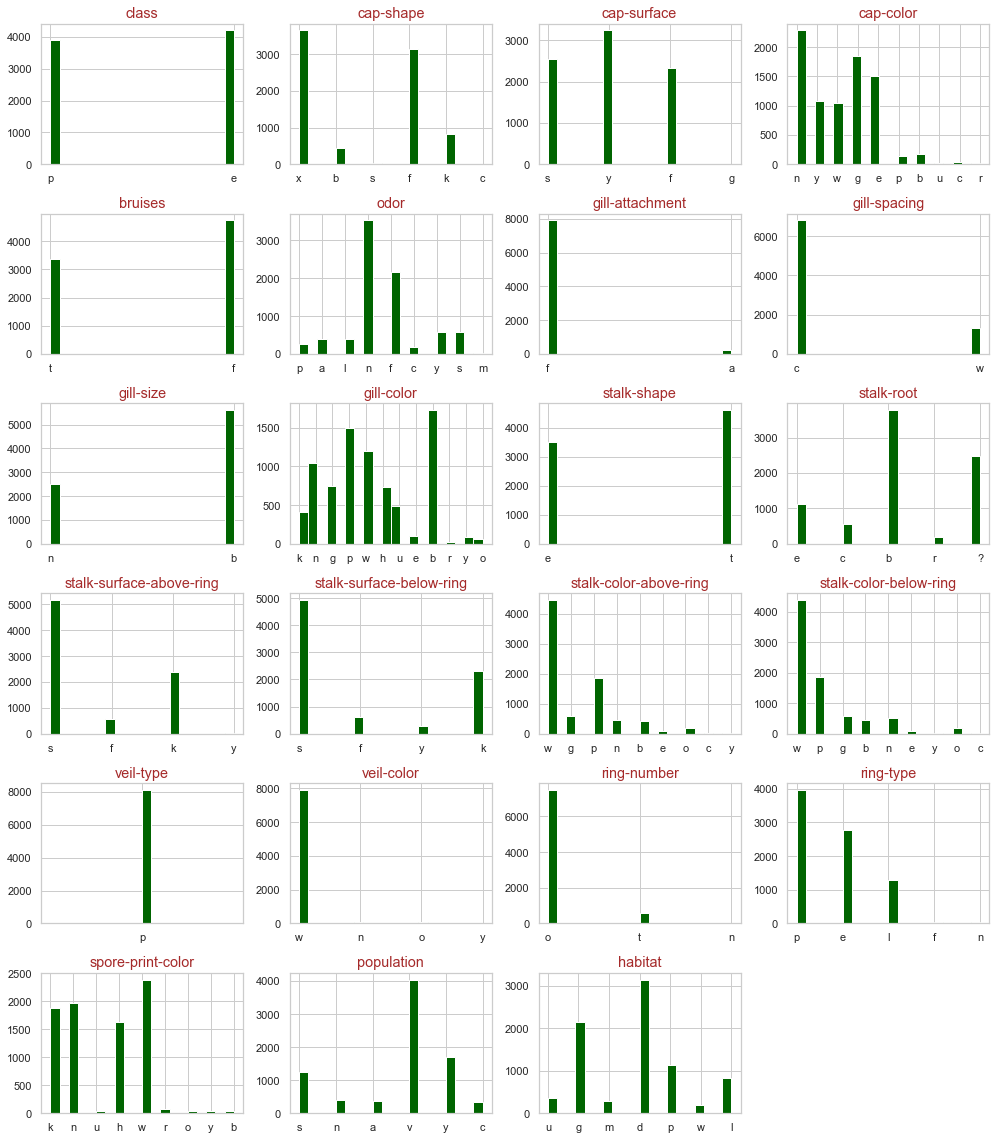

In [12]:
plot_histograms(mush_df, mush_df.columns[0:23], 6, 4)

# 3. Research

## 3.1. List of selected algorithms to build models

The following are the algorithms covering a variety of classification strategies and techniques that have been selected for the project. All models will be developed with default parameters and trained. Only a few best will be selected for algorithm tuning based on their performances (evaluation metrics). Then, each of those models will be individually tuned to minimize error. The final model will be selected based on their evaluation metrics on training and test datasets. 

#### Classification algorithms:
```
 1) Logistic Regression (LR)         LogisticRegression()            - Simple Linear
 2) SGD Classifier (SGD)             SGDClassifier()                 - Simple Linear
 3) K-Nearest Neighbors (KNN)        KNeighborsClassifier()          - Nonlinear
 4) Support Vector Machines (SVM)    SVC()                           - Nonlinear
 5) Gaussian Naive Bayes (NB)        GaussianNB()                    - Nonlinear
 6) Neural Network (NN)              MLPClassifier()                 - Nonlinear
 7) Decision Trees (DT)              DecisionTreeClassifier()        - Nonlinear
 8) Random Forest Trees (RF)         RandomForestClassifier()        - Ensemble Bagging
 9) Gradient Boosting (GB)           GradientBoostingClassifier()    - Ensemble Boosting   
10) Extreme Boosting (XGB)           XGBClassifier()                 - Ensemble Boosting
```

## 3.2. List of model evaluation metrics

#### Classification model evaluation metrics:
The following metrics have been selected as the `evaluation metrics` for training, refining and evaluating the models.
```
1) Accuracy score
```

Build the above mentioned models, with default parameters, and select the best one based on their `test` scores.

# 4. Data Preprocessing

## 4.1. Data Cleaning

### 4.1.1. Basic data cleaning

The `mushroom` dataset is clean and does not have the following, and so these basic cleaning need not be done:
* Duplicate features/columns
* Duplicate samples/rows
* Embedded characters causing data misalignment
* Inconsistent data

However, PCA will be done in section 4.4 Dimensionality Reduction.

### 4.1.2. Handling missing Categorical values

In [13]:
mush_df.groupby('stalk-root').size()

stalk-root
?    2480
b    3776
c     556
e    1120
r     192
dtype: int64

Out of 23 features, one feature `stalk-root` has `?` as one of its categorical value. Since the count is significant (2480 out of 8124), a decision has been taken to *`treat the missing value (?) as just another category`*.

## 4.2. Feature Selection

Dimensionality reduction (eg., PCA) can be considered as a feature selection proces, however, PCA will be done in section 4.4 Dimensionality Reduction.

## 4.3. Feature Engineering

Dimensionality reduction (eg., PCA) can be considered as a feature engineering proces, however, PCA will be done in section 4.4 Dimensionality Reduction.

## 4.4. Dimensionality Reduction

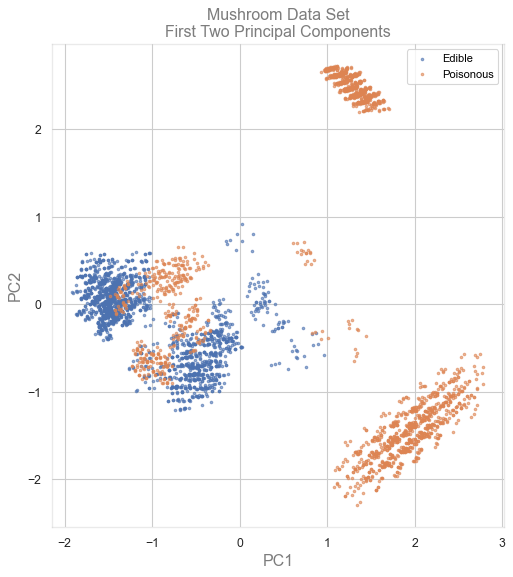

In [14]:
mush_dfd = pd.get_dummies(mush_df)
mush_dfp = mush_dfd.sample(frac=0.5, random_state=(0))  # To reduce computation time, take only 50% of the dataset for processing 

X = mush_dfp.iloc[:, 2:]                                 # Select all the attributes except the two Class attributes
y = mush_dfp.iloc[:, 1]                                  # Select the Class attribute for poisonous

pca = PCA(n_components=2).fit_transform(X)               # Select only 2 principal components

# Visualize the mushrooms dataset based on first 2 principle components
plt.figure(figsize=(8,8), dpi=80)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.6, label='Edible', s=5)
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.6, label='Poisonous', s=5)
plt.legend(fontsize='small', labelcolor='black', framealpha=0.8)
plt.title('Mushroom Data Set\nFirst Two Principal Components', size='large', alpha=0.6)
plt.xlabel('PC1', size='large', alpha=0.6)
plt.ylabel('PC2', size='large', alpha=0.6)
plt.gca().set_aspect('equal')
for spine in plt.gca().spines:
    plt.gca().spines[spine].set_alpha(0.4)

## 4.5. Split datasets for train-test

#### Keep only one dataframe (df) and delete the rest and release memory for ML processing

In [15]:
del null_values, null_values_per, null_values_df, dup_df, mush_dfd, mush_dfp

### 4.5.1. Create Independent(X) and Dependent(y) variables

Done in section 4.4 Dimensionality Reduction.

### 4.5.2. Split the dataset into *`train`* and *`test`*

In [16]:
X_train, X_test, y_train, y_test = train_test_split(pca, y, test_size=0.2, random_state=0)
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)
print('PCA    :', pca.shape)
print('y      :', y.shape)

X_train: (3249, 2)
X_test : (813, 2)
y_train: (3249,)
y_test : (813,)
PCA    : (4062, 2)
y      : (4062,)


## 4.6. Data Transforms

Not done.

## 4.7. Handling Imbalanced classes

#### Resample datasets using SMOTE and make the samples balanced for better learning

In [17]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
pca_smote, y_smote           = SMOTE().fit_resample(pca, y)

# 5. Model Development

## 5.1. Model definitions

In [18]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))

# 6. Model Training

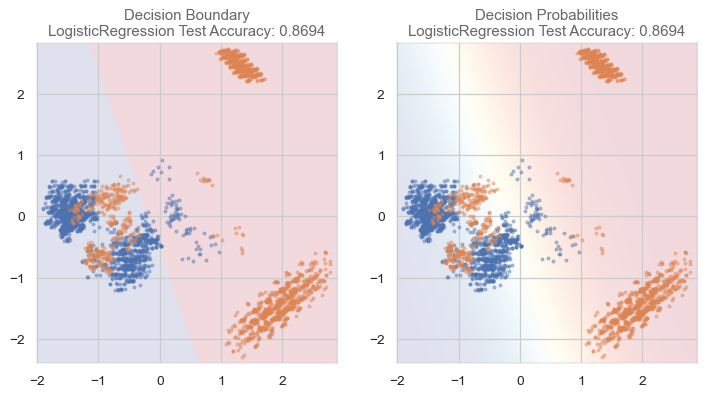

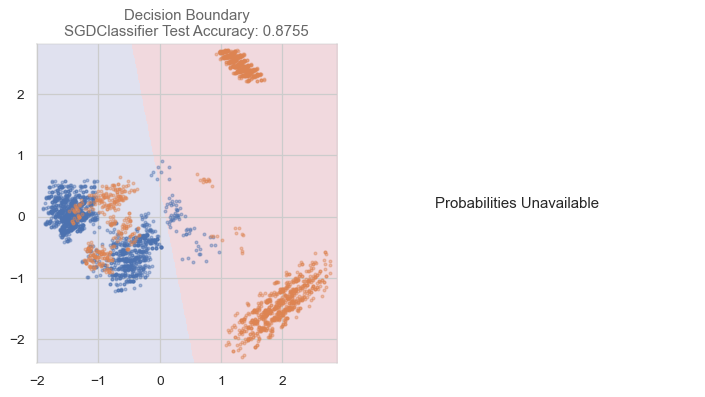

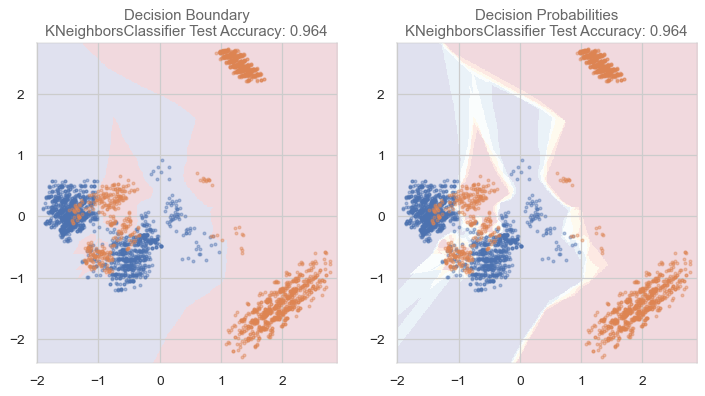

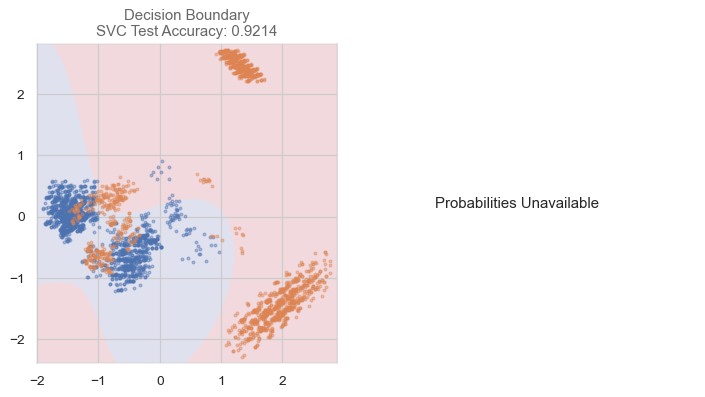

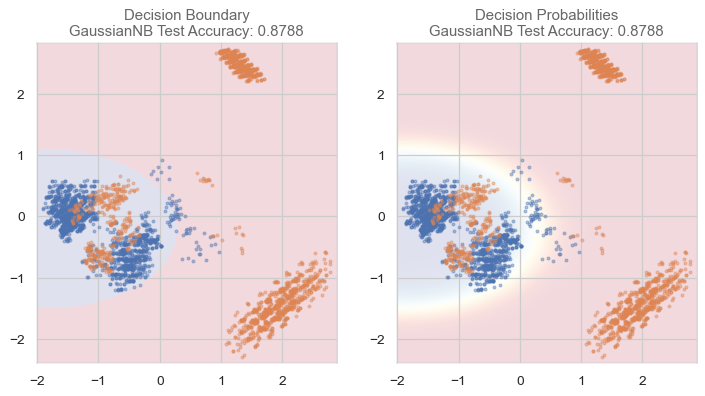

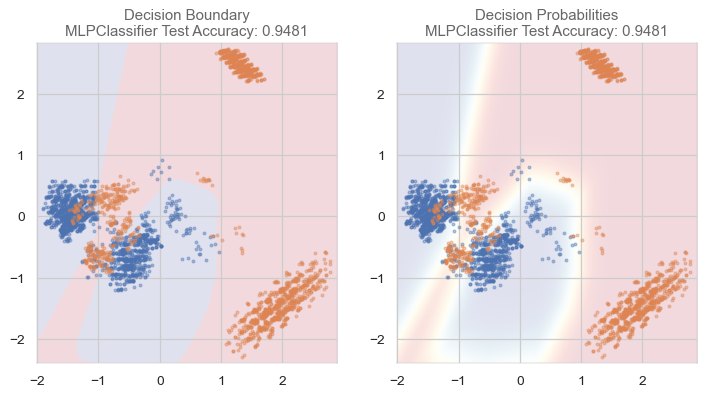

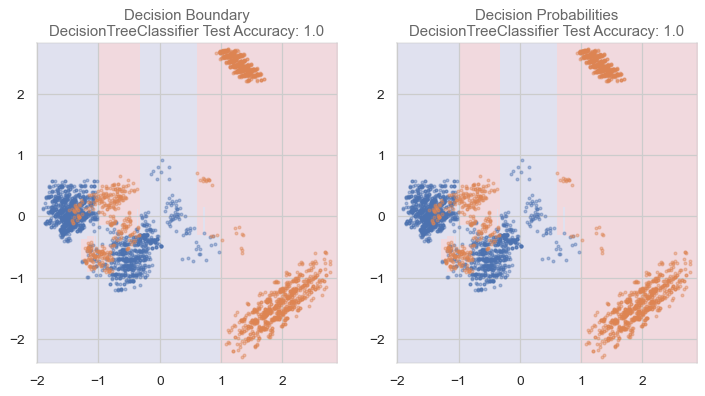

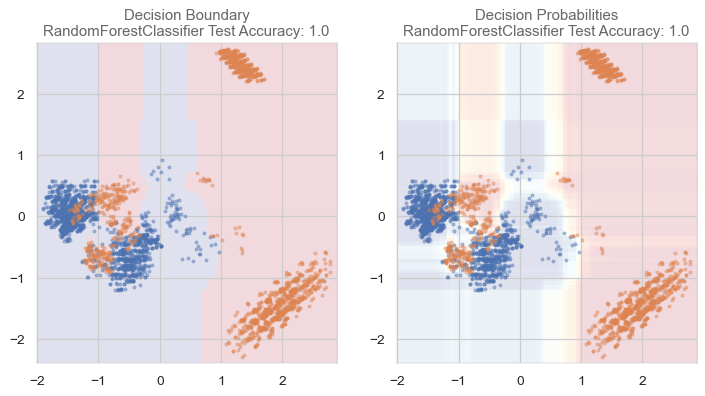

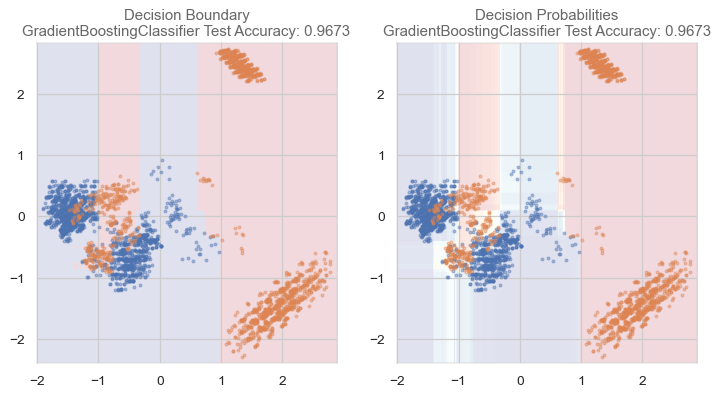

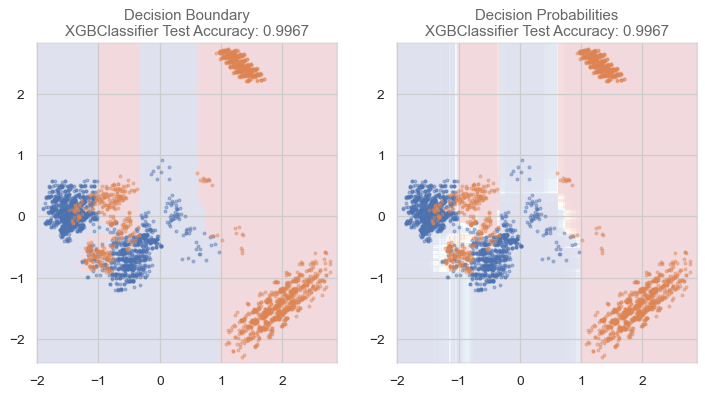

In [19]:
modelnames     = []
scores_trng    = []
trained_models = []

for name, model in models:
    modelnames.append('model'+name)
    trained_models.append(model.fit(X_train_smote, y_train_smote))
    scores_trng.append(draw_decision_boundary(X_train_smote, y_train_smote, model))

# 7. Model Refinement

Model refinement (i.e., hyperparameters optimization) is not done because 5 of 10 models achieved more than 95% accuracy, and 2 of them achieved 100% accuracy on the training dataset.

# 8. Model Evaluation

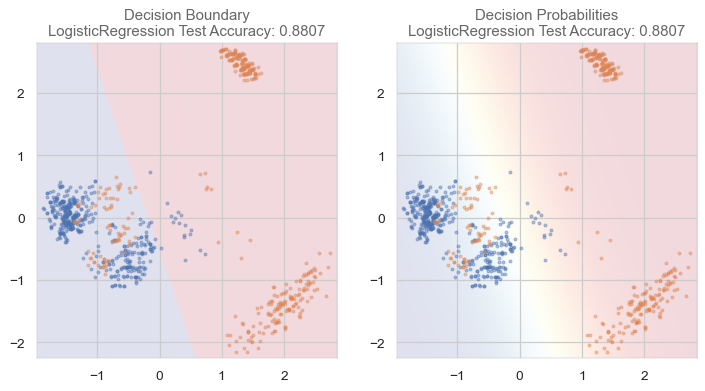

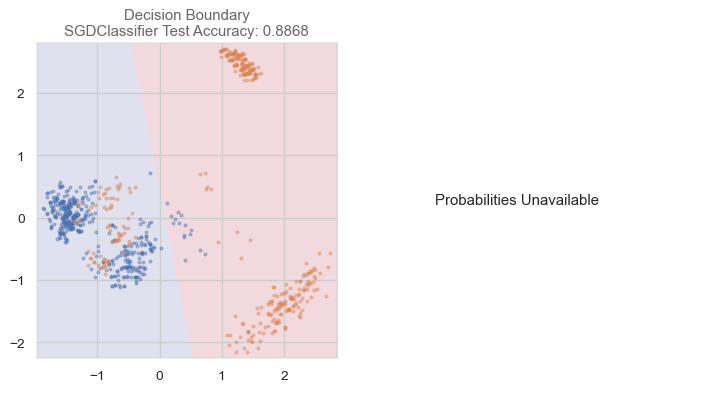

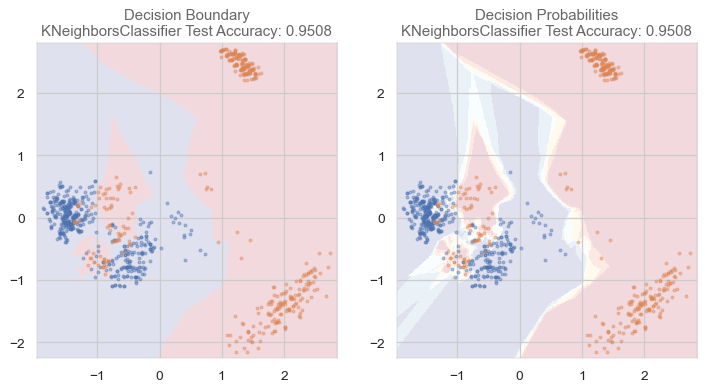

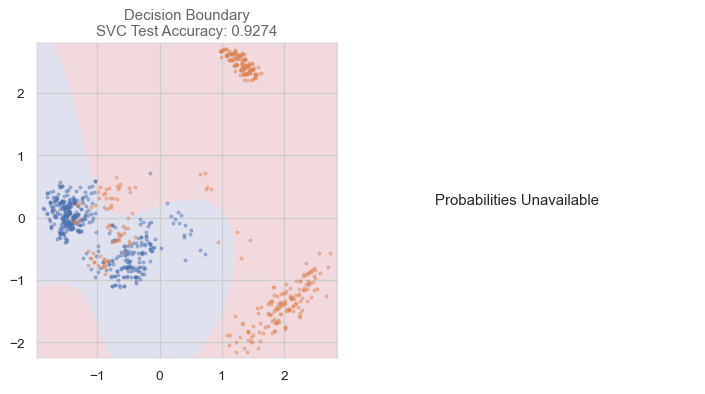

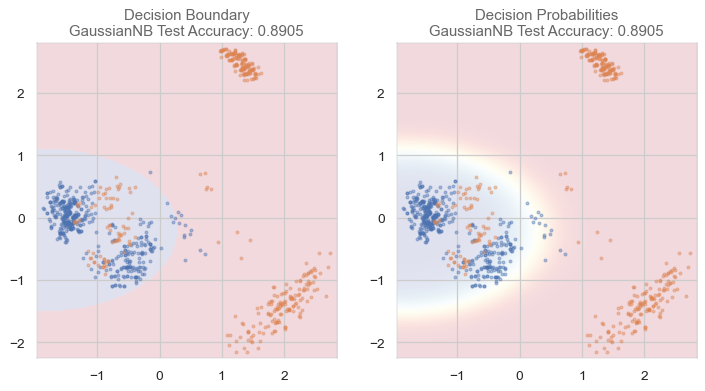

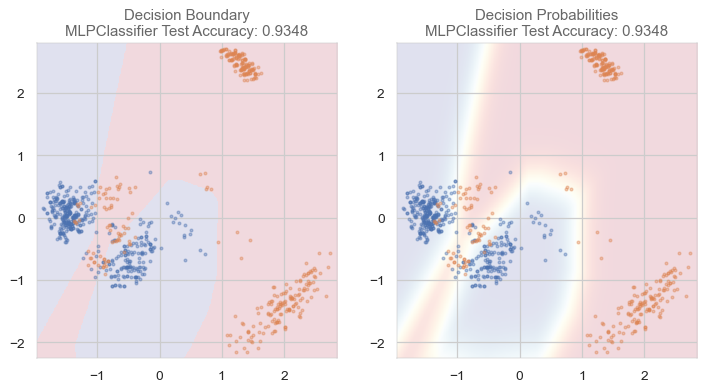

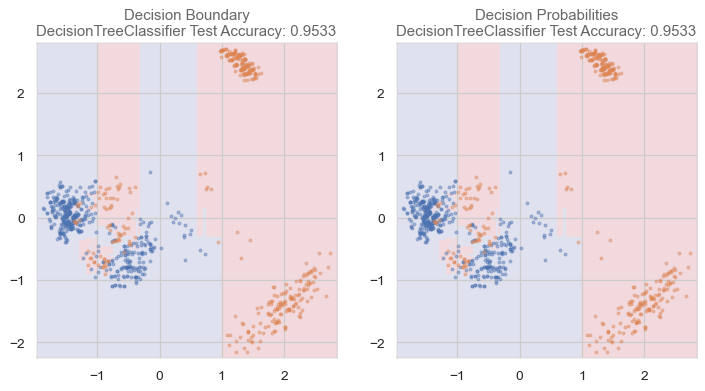

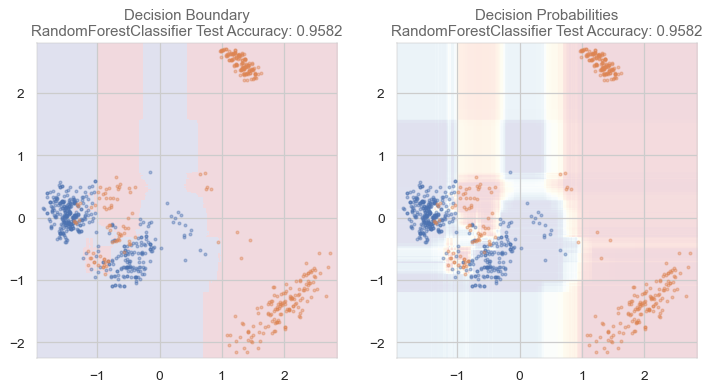

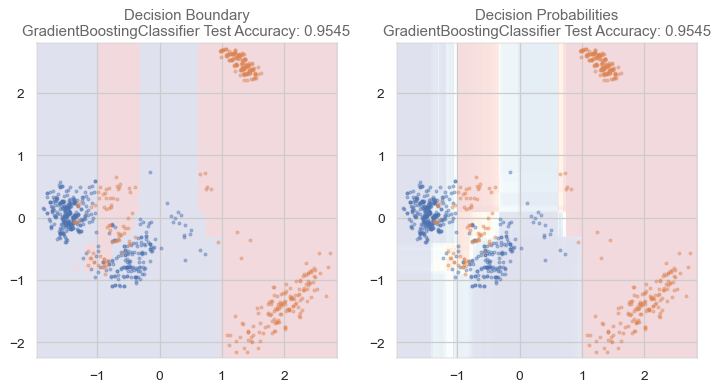

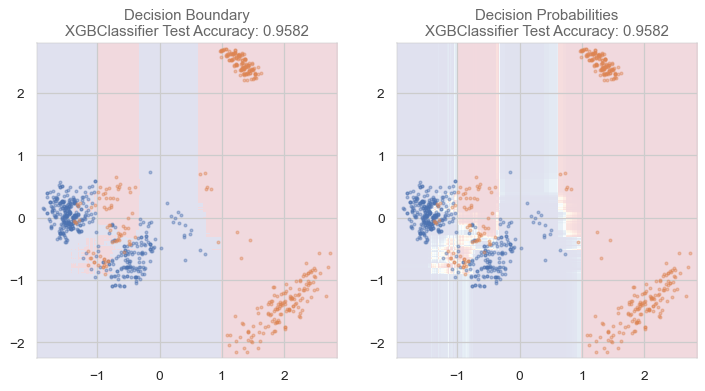

In [20]:
scores_eval = []

for model in trained_models:
    scores_eval.append(draw_decision_boundary(X_test, y_test, model))

# 9. Final Model Selection

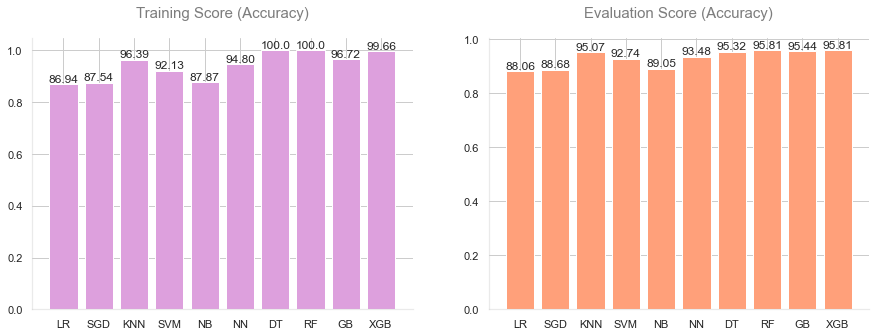

In [21]:
scores_list  = [scores_trng, scores_eval]
scores_names = ['Training Score (Accuracy)', 'Evaluation Score (Accuracy)']
colors       = ['plum', 'lightsalmon']
model_names  = ['LR', 'SGD', 'KNN', 'SVM', 'NB', 'NN', 'DT', 'RF', 'GB', 'XGB']

plot_performance_metrics(scores_list, scores_names, colors, model_names)

The scores generated during Model Training and Model Evaluation stages suggest that the **`Random Forest (RF)`** *is the winner*. Though there is tie between RF and XGB on the Evaluation score, XGB scored slightly less than RF on the Training score. Therefore, RF is the best model and it is selected as the final model. RF will be trained on the entire dataset, saved, and deployed into the test infrastructure for business user's testing (i.e., Model Validation).

In [22]:
# Train the final model on the entire dataset and save it to the disk
FinalModel = RandomForestClassifier().fit(pca, y)
ModelName = 'MLPy-DemoProj-3.sav'
pickle.dump(FinalModel, open(ModelName, 'wb'))

# 10. Model Validation

The business users perform the validations using the *`unseen UAT datasets`*.

# 11. Model Deployment

The model deployment is usually done by the DS team along with the ML team upon receipt of stakeholders sign-off.